##  Import Libraries

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import re

!pip install --upgrade wordcloud
from wordcloud import WordCloud

import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lovep\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load the Data

In [116]:
data = pd.read_csv('./data/spam.csv', encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [117]:
data.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)
print(data.shape)
data.head()

(5572, 2)


,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Check for Duplicates and Missing Data

In [118]:
data.isnull().sum()

v1    0
v2    0
dtype: int64

There is no missing data.

In [119]:
print(f'Number of duplicated entries : {data.duplicated().sum()}')
data[data.duplicated()]

Number of duplicated entries : 403


,v1,v2
102,ham,As per your request 'Melle Melle (Oru Minnamin...
153,ham,As per your request 'Melle Melle (Oru Minnamin...
206,ham,"As I entered my cabin my PA said, '' Happy B'd..."
222,ham,"Sorry, I'll call later"
325,ham,No calls..messages..missed calls
338,ham,"Sorry, I'll call later"
356,spam,Congratulations ur awarded 500 of CD vouchers ...
443,ham,"Sorry, I'll call later"
532,ham,Gudnite....tc...practice going on
654,ham,Did u got that persons story


We know there are 403 duplicated entries and we will remove them from here.

In [120]:
data.drop_duplicates(inplace=True)
print(f'Number of duplicated entries : {data.duplicated().sum()}')

Number of duplicated entries : 0


## *Renaming the columns*

In [121]:
data.rename(columns={'v1':'spam_ham','v2':'message'},inplace=True)
data.columns

Index(['spam_ham', 'message'], dtype='object')

In [122]:
data = data[['message','spam_ham']]

# Visualization of our Data

spam_ham
ham     4516
spam     653
Name: count, dtype: int64


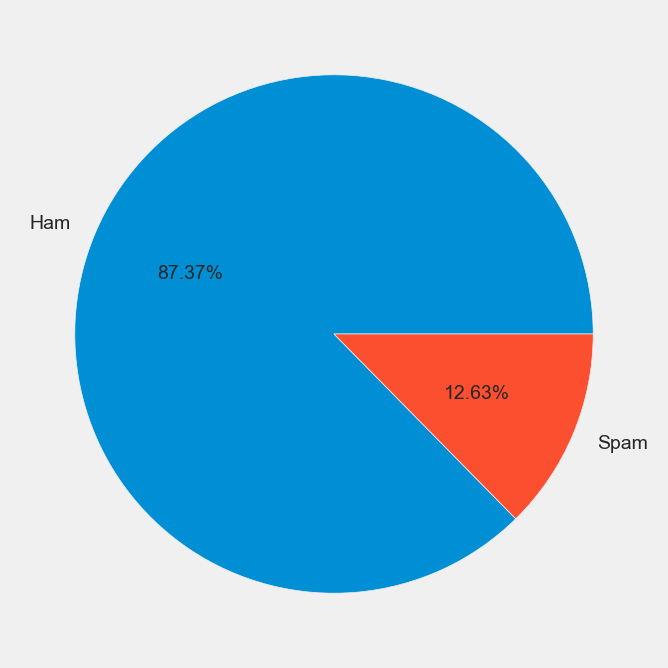

In [123]:
print(data.spam_ham.value_counts())
plt.figure(figsize=(8,8))

# data.spam_ham.hist()
plt.pie(data.spam_ham.value_counts(),labels=['Ham','Spam'],autopct='%0.2f%%')
plt.show()

From here we know that the dataset is **highly skewed** and mainly consist of ham data.

In [124]:
# lb = LabelEncoder()
# data.spam_ham = lb.fit_transform(data.spam_ham) 

data.spam_ham = data.spam_ham.replace({'ham':0,'spam':1})

#rename the column again
data.rename(columns={'spam_ham':'spam'},inplace=True)

data.head()

,message,spam
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


## Data Transformation 

In [125]:
lem = WordNetLemmatizer()
ps = PorterStemmer()

In [126]:
# corpus = []
        
# for i in range(0,len(data)):
#     review = re.sub('[^a-zA-Z]',' ',data.iloc[i]['message'])
#     review = review.lower()
#     review = review.split()
    
#     review = [lem.lemmatize(word) for word in review if word not in stopwords.words('english') ]
#     review = ' '.join(review)
#     corpus.append(review)

# df = pd.DataFrame(corpus, columns=['processed_message'])
# df = pd.concat([data,df],axis=1)
# df

In [127]:
def transform_text(data): 
    #removing characters that are not words
    text = re.sub('[^a-zA-Z]',' ',data)
    text = text.lower()
    text = text.split()
    
#   transformed_text = [ps.stem(word) for word in text if word not in stopwords.words('english') ]
    transformed_text = [lem.lemmatize(word) for word in text if word not in stopwords.words('english') ]
    transformed_text = ' '.join(transformed_text)
    return transformed_text

In [128]:
st = time.time()        

data['transformed_text'] = data.message.apply(transform_text)
et = time.time()

print(et-st)
data.head()

38.18327236175537


,message,spam,transformed_text
0,"Go until jurong point, crazy.. Available only ...",0,go jurong point crazy available bugis n great ...
1,Ok lar... Joking wif u oni...,0,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry wkly comp win fa cup final tkts st ...
3,U dun say so early hor... U c already then say...,0,u dun say early hor u c already say
4,"Nah I don't think he goes to usf, he lives aro...",0,nah think go usf life around though


In [129]:
data['num_characters'] = data.message.apply(len)
data['lem_num_characters'] = data.transformed_text.apply(lambda x : len(nltk.word_tokenize(x)))
data['num_sentence'] = data.transformed_text.apply(lambda x : len(nltk.sent_tokenize(x)))

In [130]:
data.head()

,message,spam,transformed_text,num_characters,lem_num_characters,num_sentence
0,"Go until jurong point, crazy.. Available only ...",0,go jurong point crazy available bugis n great ...,111,16,1
1,Ok lar... Joking wif u oni...,0,ok lar joking wif u oni,29,6,1
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry wkly comp win fa cup final tkts st ...,155,21,1
3,U dun say so early hor... U c already then say...,0,u dun say early hor u c already say,49,9,1
4,"Nah I don't think he goes to usf, he lives aro...",0,nah think go usf life around though,61,7,1


# Saved Transformed Data in csv file

In [131]:
ham_data = data[data['spam']==0]
spam_data = data[data['spam']==1]

ham_data.to_csv('./data/processed_ham.csv',index=False)
spam_data.to_csv('./data/processed_spam.csv',index=False)

## Further Visualization of Spam & Ham Data

In [132]:
processed_ham = pd.read_csv('./data/processed_ham.csv')
processed_spam = pd.read_csv('./data/processed_spam.csv')

processed_ham.head(50) 

,message,spam,transformed_text,num_characters,lem_num_characters,num_sentence
0,"Go until jurong point, crazy.. Available only ...",0,go jurong point crazy available bugis n great ...,111,16,1
1,Ok lar... Joking wif u oni...,0,ok lar joking wif u oni,29,6,1
2,U dun say so early hor... U c already then say...,0,u dun say early hor u c already say,49,9,1
3,"Nah I don't think he goes to usf, he lives aro...",0,nah think go usf life around though,61,7,1
4,Even my brother is not like to speak with me. ...,0,even brother like speak treat like aid patent,77,8,1
5,As per your request 'Melle Melle (Oru Minnamin...,0,per request melle melle oru minnaminunginte nu...,160,15,1
6,I'm gonna be home soon and i don't want to tal...,0,gonna home soon want talk stuff anymore tonigh...,109,13,1
7,I've been searching for the right words to tha...,0,searching right word thank breather promise wo...,196,15,1
8,I HAVE A DATE ON SUNDAY WITH WILL!!,0,date sunday,35,2,1
9,Oh k...i'm watching here:),0,oh k watching,26,3,1


# Data Visualization & Wordcloud for Messages

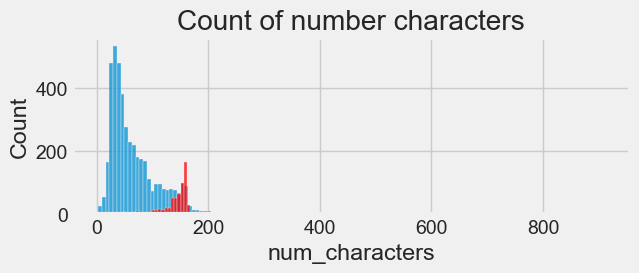

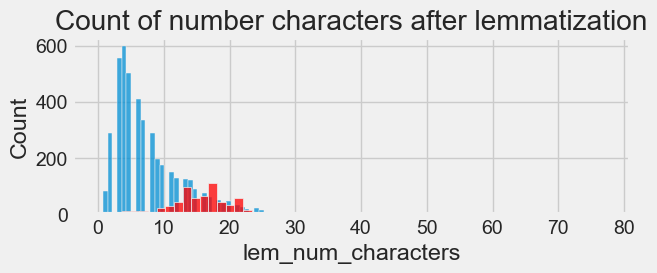

In [133]:
# plt.figure(figsize=(10,14))
plt.subplot(2,1,1)
sns.histplot(data[data['spam'] == 0]['num_characters'])
sns.histplot(data[data['spam'] == 1]['num_characters'],color='red')
plt.title('Count of number characters')
plt.show()

plt.subplot(2,1,2)
sns.histplot(data[data['spam'] == 0]['lem_num_characters'])
sns.histplot(data[data['spam'] == 1]['lem_num_characters'],color='red')
plt.title('Count of number characters after lemmatization')
plt.show()

## *Wordcloud of Spam Messages*

In [134]:
wc = WordCloud(width=1000,height=1000,min_font_size=8,background_color='white')

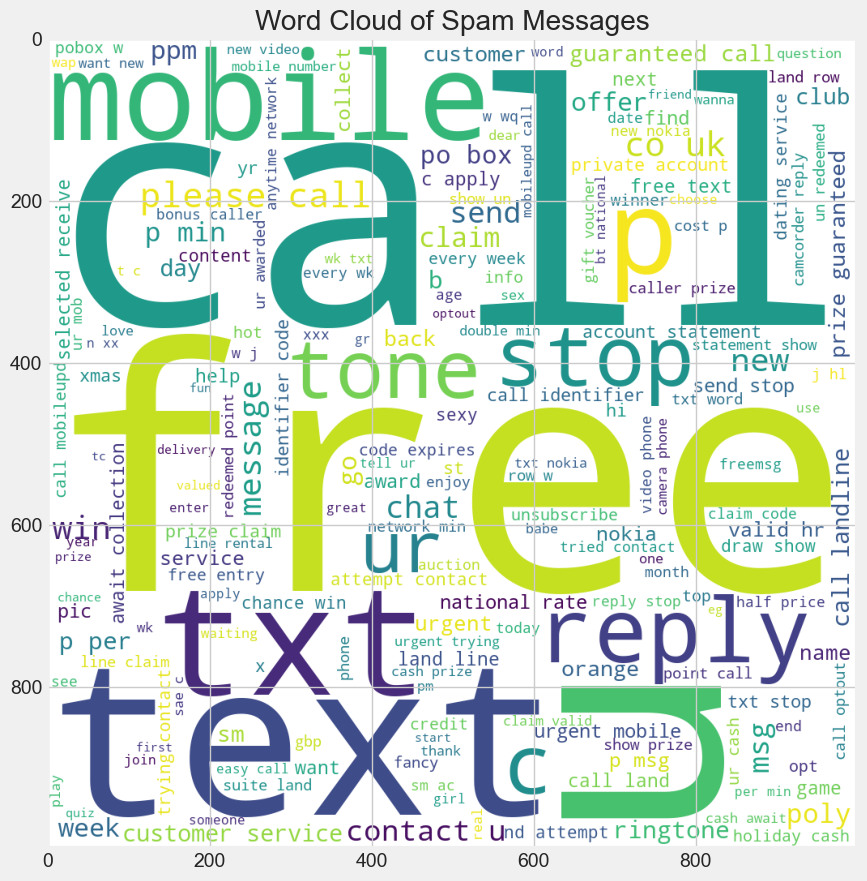

In [135]:
spam_wc = wc.generate(data[data.spam==1].transformed_text.str.cat(sep=" "))
plt.figure(figsize=(20,10))
plt.imshow(spam_wc)
plt.title('Word Cloud of Spam Messages')
plt.show()

## *Wordcloud of Ham Messages*

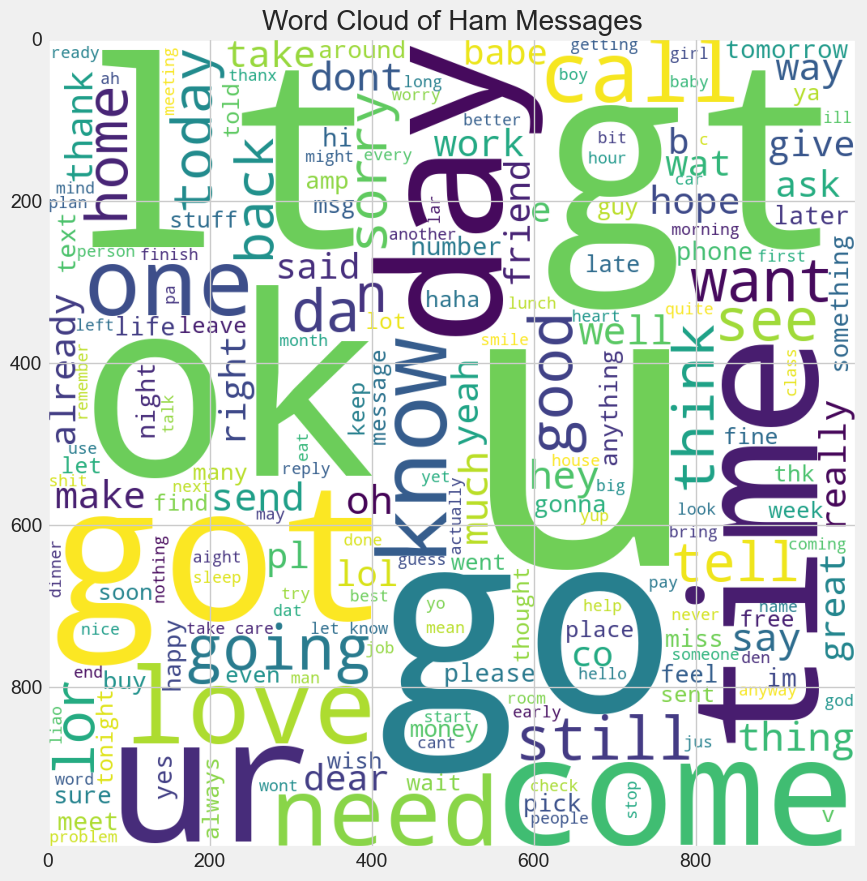

In [136]:
spam_wc = wc.generate(data[data.spam==0].transformed_text.str.cat(sep=" "))
plt.figure(figsize=(20,10))
plt.imshow(spam_wc)
plt.title('Word Cloud of Ham Messages')
plt.show()

In [137]:
spam_corpus=[]

for msg in tqdm(data[data.spam==1]['transformed_text'].to_list()):
    for word in msg.split():
        spam_corpus.append(word)
        
len(spam_corpus)        

100%|████████████████████████████████████████████████████████████████████████████| 653/653 [00:00<00:00, 156892.97it/s]


10068

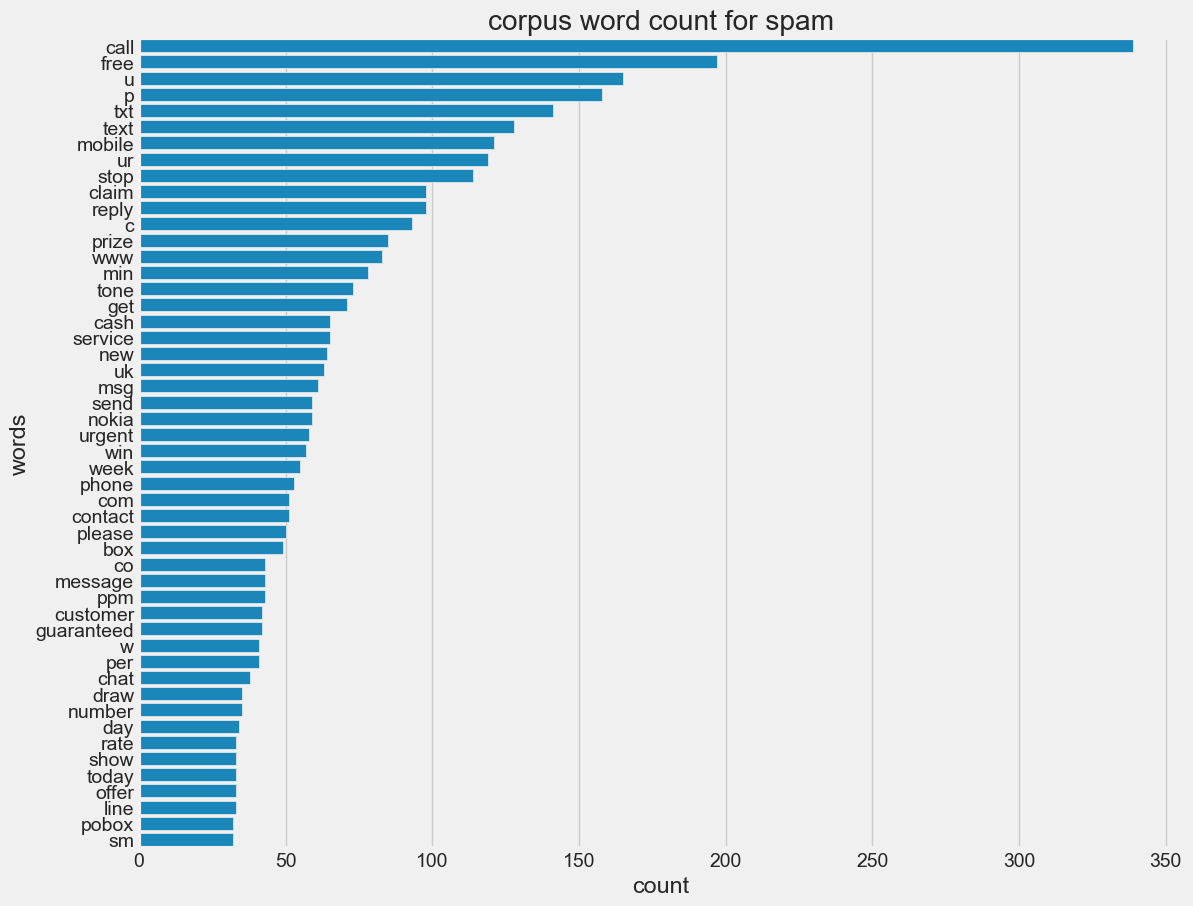

In [138]:
from collections import Counter

spam_top_50_words = pd.DataFrame(Counter(spam_corpus).most_common(50))
# spam_top_50_words

plt.figure(figsize=(12,10))
sns.barplot(y=spam_top_50_words[0],x=spam_top_50_words[1])
plt.ylabel('words')
plt.xlabel('count')
plt.title('corpus word count for spam')
plt.yticks(rotation='horizontal')
plt.show()

In [139]:
ham_corpus=[]

for msg in tqdm(data[data.spam==0]['transformed_text'].to_list()):
    for word in msg.split():
        ham_corpus.append(word)
        
len(ham_corpus) 

100%|██████████████████████████████████████████████████████████████████████████| 4516/4516 [00:00<00:00, 205434.56it/s]


35388

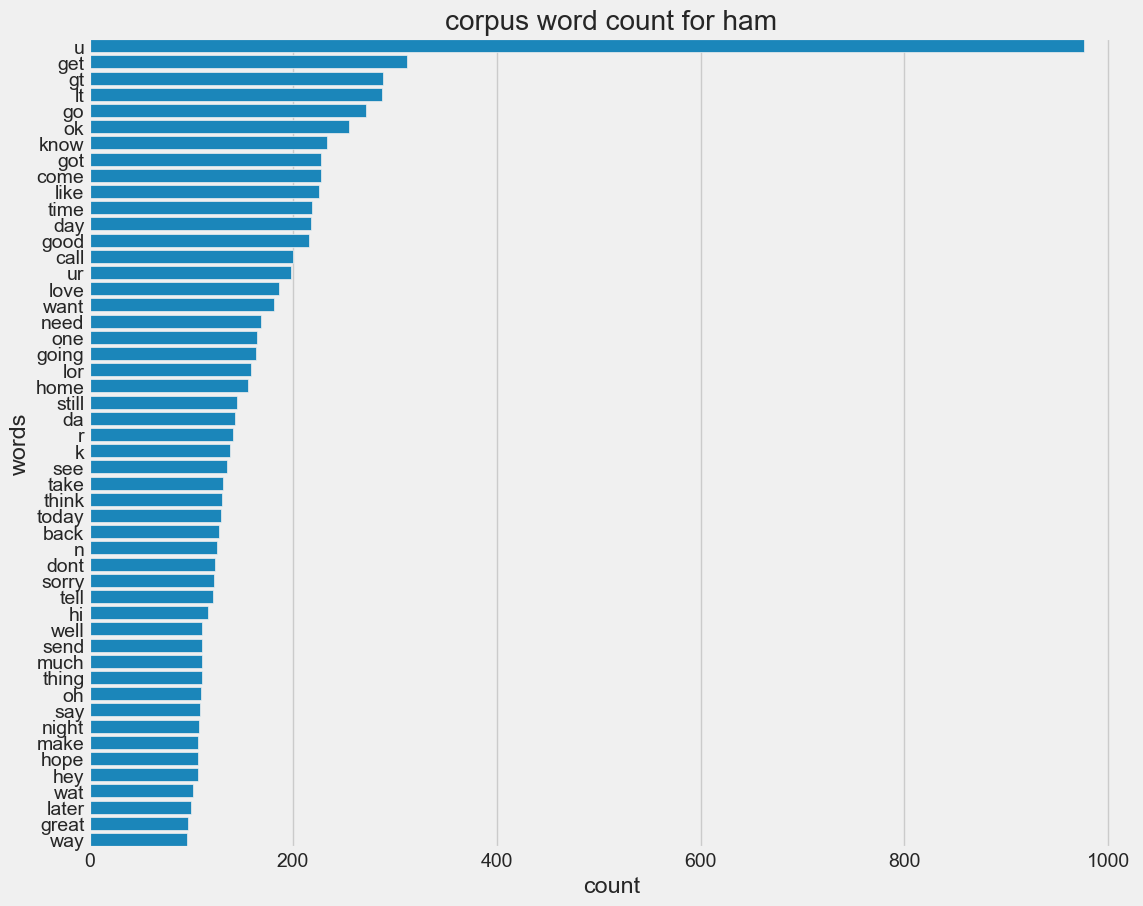

In [140]:
ham_top_50_words = pd.DataFrame(Counter(ham_corpus).most_common(50))
# ham_top_50_words

plt.figure(figsize=(12,10))
sns.barplot(y=ham_top_50_words[0],x=ham_top_50_words[1])
plt.ylabel('words')
plt.xlabel('count')
plt.title('corpus word count for ham')
plt.yticks(rotation='horizontal')
plt.show()
plt.show()

# Vectorization of the Text

In [141]:
cv = CountVectorizer(max_features=2500)
# tfidf = TfidfVectorizer(max_features=2500,min_df=20)
X = cv.fit_transform(data.transformed_text)
# X = tfidf.fit_transform(data.transformed_text)
print(type(X),X.shape)
X = X.toarray()
type(X)

<class 'scipy.sparse._csr.csr_matrix'> (5169, 2500)


numpy.ndarray

In [142]:
y = data.spam
y[:10]

0    0
1    0
2    1
3    0
4    0
5    1
6    0
7    0
8    1
9    1
Name: spam, dtype: int64

In [143]:
type(y.value_counts().values)

numpy.ndarray

##  *Train-Test Split the Data*

In [144]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(4135, 2500) (4135,) (1034, 2500) (1034,)


#  Model Training


## *SVC Model*


In [145]:
model1 = LinearSVC().fit(X_train,y_train)
print("Model Training score : ",model1.score(X_train,y_train))

C:\Users\lovep\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Model Training score :  1.0


##  *Naive Bayes Model*

In [146]:
model = MultinomialNB().fit(X_train,y_train)
print("Model Training score : ",model.score(X_train,y_train))

Model Training score :  0.9898428053204353


In [147]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report

#function to evaluate the performance of model
def evaluate_model_performance(model,x_test,y_test):
    y_pred=model.predict(x_test)
    print("Accurary Score : {}".format(np.round(accuracy_score(y_test,y_pred)*100,decimals=2)))
    print("Precision Score : {}".format(np.round(precision_score(y_test,y_pred)*100,decimals=2)))
    print("Recall Score : {}".format(np.round(recall_score(y_test,y_pred)*100,decimals=2)))
    print("F1 Score : {}".format(np.round(f1_score(y_test,y_pred)*100,decimals=2)))
    cm=confusion_matrix(y_test,y_pred)
    sns.heatmap(cm,fmt="d",annot=True,cmap="Blues")
    plt.title('Confusion Matrix')
    plt.show()
    print("*********************************************Classification Report*********************************************")
    print(classification_report(y_test,y_pred))

Accurary Score : 98.07
Precision Score : 96.3
Recall Score : 89.66
F1 Score : 92.86


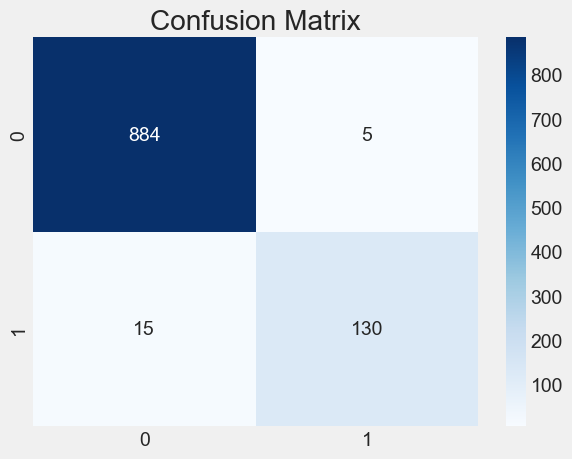

*********************************************Classification Report*********************************************
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       889
           1       0.96      0.90      0.93       145

    accuracy                           0.98      1034
   macro avg       0.97      0.95      0.96      1034
weighted avg       0.98      0.98      0.98      1034



In [148]:
# SVC model performance
evaluate_model_performance(model1,X_test,y_test)

Accurary Score : 97.58
Precision Score : 88.96
Recall Score : 94.48
F1 Score : 91.64


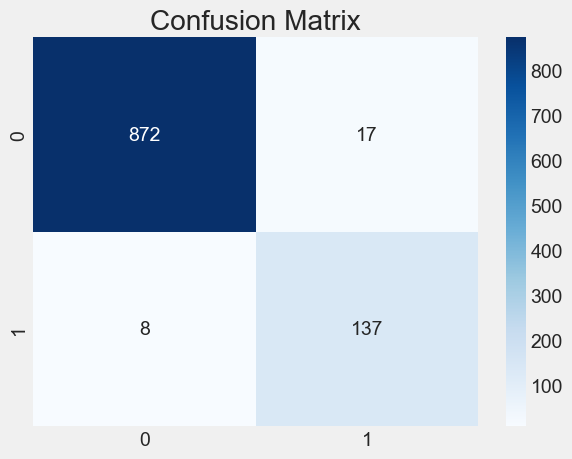

*********************************************Classification Report*********************************************
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       889
           1       0.89      0.94      0.92       145

    accuracy                           0.98      1034
   macro avg       0.94      0.96      0.95      1034
weighted avg       0.98      0.98      0.98      1034



In [149]:
#NB model performance
evaluate_model_performance(model,X_test,y_test)

In [150]:
text_list = ['Enter the message to check for spam: Congratulations! You’ve won a free iPhone 12\
. To claim your prize, please follow the link below: /''[link]']
text = cv.transform(text_list)
predict = model1.predict(text)[0]
predict

1

In [151]:
def predict(text):      
    text_list = [text]
    text = cv.transform(text_list)
    predict = model1.predict(text)[0]
    if predict == 0 :
        print('************************ham************************')
    else:
        print('************************spam************************')
#         print('spam')
    return predict

In [152]:
text = input("Enter the message to check for spam: ")
print('\n')
predict(text)

Enter the message to check for spam: helo


************************ham************************


0

In [153]:
import pickle

pickle.dump(cv,open('cv.pkl','wb'))
pickle.dump(model1,open('model.pkl','wb'))

In [ ]:
# import re

# text = " <a href='https://example.com'>links</a> and <img src='image.jpg'/>."

# regex_pattern = r'(<[\w\s]*/?>)'
# matches = re.findall(regex_pattern, text)

# print(matches)


In [ ]:
# print("abaababbaabbaababaabbaba"==
#       "abaababbaabbaababaabbaba")